In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [99]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [54]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [55]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

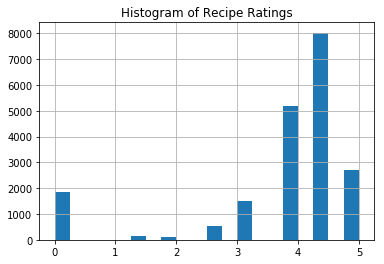

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [83]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Around 5-7 mins. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

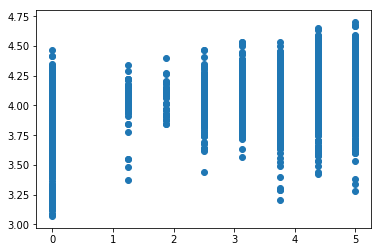

In [9]:
plt.scatter(Y, svr.predict(X))

Now that is a pretty useless visualization. This is because of the discontinuous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [57]:
svr.score(X, Y)

-0.003978314483867873

In [84]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([-0.01795256, -0.05267349, -0.08449747, -0.11070167, -0.00017704])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

In [94]:
import warnings
warnings.filterwarnings('ignore')

In [95]:
#Function for visualizing strongest features in the model.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVR

def plot_coefficients(classifier, feature_names, top_features=20):
        coef = classifier.coef_.ravel()
        top_positive_coefficients = np.argsort(coef)[-top_features:]
        top_negative_coefficients = np.argsort(coef)[:top_features]
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
        # create plot
        plt.figure(figsize=(15, 5))
        colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
        plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
        plt.show()

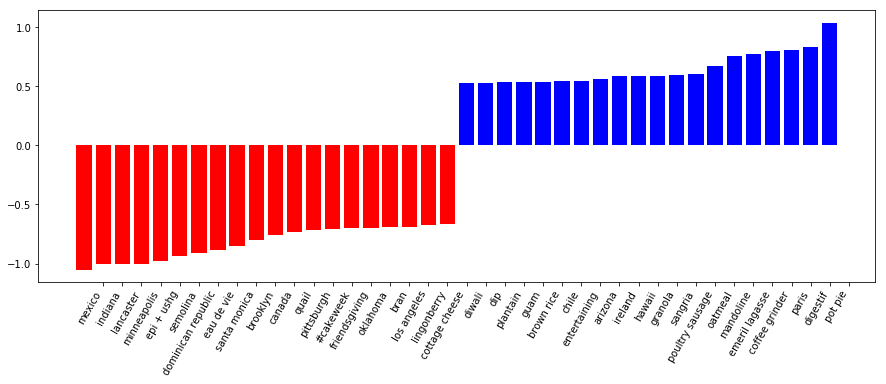

In [103]:
#Running model with on 0.3 proportion of the data and excluding nutritional information. Using linear SVR to extract coefficients
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)

lsvr = LinearSVR()
lsvr.fit(X,Y)
plot_coefficients(lsvr, X.columns)

In [104]:
#Extracing the 30 Best Features
coef = lsvr.coef_.ravel()
ftr_ranks = 15
#top_positive_coefficients = np.argsort(coef)[-ftr_ranks:]
top_negative_coefficients = np.argsort(coef)[:ftr_ranks]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
top_feature_names = X.columns[top_coefficients]
top_feature_names

Index(['mexico', 'indiana', 'lancaster', 'minneapolis', 'epi + ushg',
       'semolina', 'dominican republic', 'eau de vie', 'santa monica',
       'brooklyn', 'canada', 'quail', 'pittsburgh', '#cakeweek',
       'friendsgiving', 'pot pie', 'mandoline', 'guava', 'granola', 'iced tea',
       'oatmeal', 'pizza', 'grappa', 'sangria', 'champagne', 'vodka',
       'snack week', 'organic', 'rosé', 'coffee grinder', 'emeril lagasse',
       'cranberry sauce', 'flat bread', 'meatball', 'hot drink'],
      dtype='object')

In [91]:
svr = SVR()
X = raw_data.sample(frac=0.3, replace=True, random_state=1)[top_feature_names]
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)
cross_val_score(svr, X, Y, cv=5)

array([-0.42858459, -0.46940569, -0.45063819, -0.50493852, -0.42791068])

In [106]:
from sklearn.svm import SVC

#binarizing rating
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')
data = raw_data
data.loc[data['rating'] < 4, 'rating'] = 0
data.loc[data['rating'] >= 4, 'rating'] = 1

#Setting dependent and target variables
X = data.sample(frac=0.3, replace=True, random_state=2)[top_feature_names]
Y = data.rating.sample(frac=0.3, replace=True, random_state=2)
X_test = data[top_feature_names]
Y_test = data.rating

#Fitting and Crossvalidating SVR model
svc = SVC()
svc.fit(X,Y)
cross_val_score(svc, X, Y, cv=5)

array([0.54734219, 0.54779717, 0.54779717, 0.54779717, 0.54696592])

In [108]:
cross_val_score(svc, X_test, Y_test, cv=10)

array([0.53539382, 0.53539382, 0.53539382, 0.53539382, 0.53566085,
       0.53566085, 0.53566085, 0.53566085, 0.53542914, 0.53542914])

In [112]:
# Percantage of data that is 1
data[data['rating']==1]['rating'].count()/len(data)

0.5355076800319171

This is not at all better than just guessing. After gathering the 30 strongest features among the data, I feel that this is the best that I can be done with just tampering with the features. However, one thing that was definitely improved upon was the overfitting, because the cross validation returns consistent accuracy scores across each fold.

Next Possible Steps:
- Including the nutritional information as features see if it improves accuracy of the model.
- Checking to see if only including positively correlated features helps to improve the model.
- Running PCA for 30 estimators despite knowing exact features won't be extractable.

### Iteration 1: Including Nutritional Information

In [128]:
#Creating model with nutritional information. Rows without nutritional information excluded.
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')
data = raw_data.dropna(axis=0)

#Storing Index for later use
nutri_index = data.index

X = data.drop(['rating','title'], 1).dropna(axis=0).sample(frac=0.3, replace=True, random_state=1)
Y = data['rating'].sample(frac=0.3, replace=True, random_state=1)

lsvr = LinearSVR()
lsvr.fit(X,Y)

#Extracting the 30 Best Features
coef = lsvr.coef_.ravel()
ftr_ranks = 15
top_positive_coefficients = np.argsort(coef)[-ftr_ranks:]
top_negative_coefficients = np.argsort(coef)[:ftr_ranks]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
top_feature_names = X.columns[top_coefficients]
top_feature_names

Index(['seed', 'barley', 'spirit', 'clam', 'oregano', 'tea', 'vinegar', 'raw',
       'drink', 'cream cheese', 'harpercollins', 'kid-friendly', 'yogurt',
       'veal', 'weelicious', 'appetizer', 'chicken', 'mayonnaise', 'blender',
       'lemon', 'thanksgiving', 'jam or jelly', 'champagne', 'mustard',
       'low cholesterol', 'cumin', 'gourmet', 'fruit juice', 'white wine',
       'bon appétit'],
      dtype='object')

In [122]:
data.loc[data['rating'] < 4, 'rating'] = 0
data.loc[data['rating'] >= 4, 'rating'] = 1

#Setting dependent and target variables
X = data.sample(frac=0.3, replace=True, random_state=2)[top_feature_names]
Y = data.rating.sample(frac=0.3, replace=True, random_state=2)
X_test = data[top_feature_names]
Y_test = data.rating

#Fitting and Crossvalidating SVC model
svc = SVC()
svc.fit(X,Y)
cross_val_score(svc, X, Y, cv=5)

array([0.57142857, 0.57037815, 0.56617647, 0.56722689, 0.56782334])

Including the nutritional information in the model increased the cross validated accuracy scores by roughly 3%. We will therefore continue to use the nutritional information in following iterations of the model. Also, the CV scores remained consistent.

### Iteration 2: Including only positively correlated features in the model

In [129]:
data = raw_data.iloc[nutri_index.values]

X = data.drop(['rating','title'], 1).dropna(axis=0).sample(frac=0.3, replace=True, random_state=1)
Y = data['rating'].sample(frac=0.3, replace=True, random_state=1)

lsvr = LinearSVR()
lsvr.fit(X,Y)

lsvr = LinearSVR()
lsvr.fit(X,Y)

#Extracting the 30 Best Positively Correlated Features
coef = lsvr.coef_.ravel()
ftr_ranks = 30
top_positive_coefficients = np.argsort(coef)[-ftr_ranks:]
top_feature_names = X.columns[top_positive_coefficients]
top_feature_names

Index(['ginger', 'beef', 'whole wheat', 'no sugar added', 'low/no sugar',
       'turkey', 'spice', 'pomegranate', 'watermelon', 'breakfast', 'easter',
       'sauté', 'drinks', 'iced coffee', 'shower', 'appetizer', 'chicken',
       'mayonnaise', 'blender', 'thanksgiving', 'lemon', 'jam or jelly',
       'champagne', 'mustard', 'low cholesterol', 'cumin', 'gourmet',
       'fruit juice', 'white wine', 'bon appétit'],
      dtype='object')

In [131]:
data.loc[data['rating'] < 4, 'rating'] = 0
data.loc[data['rating'] >= 4, 'rating'] = 1

#Setting dependent and target variables
X = data.sample(frac=0.3, replace=True, random_state=2)[top_feature_names]
Y = data.rating.sample(frac=0.3, replace=True, random_state=2)
X_test = data[top_feature_names]
Y_test = data.rating

#Fitting and Crossvalidating SVC model
svc = SVC()
svc.fit(X,Y)
cross_val_score(svc, X, Y, cv=5)

array([0.56092437, 0.55252101, 0.54936975, 0.55567227, 0.54574132])

Utilizing only the positively correlated features reduced the overall accuracy by roughly 1 to 2 percentage points from the last model iteration. Overall consistency in CV accuracy maintained.

### Iteration 3: Using PCA to reduce data set to 30 features

In [143]:
from sklearn.decomposition import PCA

#Removing Columns with NA and binarizing the rating outcome
data = raw_data.iloc[nutri_index.values]
data.loc[data['rating'] < 4, 'rating'] = 0
data.loc[data['rating'] >= 4, 'rating'] = 1

#Setting feature elements for dependent and target data
X = data.drop(['rating', 'title'], 1)
Y = data['rating']

#Performing PCA Transformation on X
pca = PCA(n_components=30)
X = pca.fit_transform(X)
X = pd.DataFrame(data = X)

#Fitting and Cross Validating SVC model
svc = SVC()
svc.fit(X,Y)
cross_val_score(svc, X, Y, cv=5)

array([0.60869565, 0.6057359 , 0.61613615, 0.61317781, 0.61885246])

Although this is obviously not helpful in deciding the specific words that best predict the rating of a recipe, it is the most accurately predictive model yet.